<a href="https://colab.research.google.com/github/mateusz-wozny/IMO/blob/main/GreedyCycle2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 1

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def createDistanceMatrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]
  return np.array(outputMatrix)

In [ ]:
def chooseNearestVertex(matrix, used_vertexes, node):
  return np.argmin([matrix[node][i] if i not in used_vertexes and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculateCycleLength(matrix, vertexes):
  length = 0
  for graph in vertexes:
    length += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])

#   print(length)
  return length

In [ ]:
def find_nearest(matrix, lista, unvisited):
    df = matrix[:, lista][unvisited, :]
    indx, indy = np.unravel_index(df.argmin(), df.shape)
    return unvisited[indx], lista[indy]

In [ ]:
def random_heuristic(matrix, start):
    N = matrix.shape[0]
    a = random.sample(range(N), N)
    list1 = a[:N//2]
    list1.append(list1[0])
    list2 = a[N//2:]
    list2.append(list2[0])
    return [list1, list2]

In [ ]:
def nearest_neighbor(matrix, start):
    end = np.argmax(matrix[start, :])
    unvisited = list(range(matrix.shape[0]))
    unvisited.remove(start)
    unvisited.remove(end)
    list1 = [start]
    list2 = [end]
    while len(unvisited) != 0:
        nearest, vertex = find_nearest(matrix, list1, unvisited)
        list1.insert(list1.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
        if len(unvisited) == 0:
          break
        nearest, vertex = find_nearest(matrix, list2, unvisited)
        list2.insert(list2.index(vertex) + 1, nearest)
        unvisited.remove(nearest)
    list1.append(start)
    list2.append(end)

    return [list1, list2]

In [ ]:
def greedyCycle(matrix, start_node):
    #Starting node 2
    start_node_2 = np.argmax(matrix[start_node])

    #Choosing nearest vertex for cycles
    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    #Creating cycles
    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    #Calculating cycles
    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]

        z = np.inf
        x = np.inf
        c = np.inf

        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                if value < z:
                    z = value
                    x = j + 1
                    c = nearest

        if len(cycles[0]) <= len(cycles[1]):
            cycles[0].insert(x, c)
        else:
            cycles[1].insert(x, c)

    return cycles

In [ ]:
def two_regret(matrix, start_node):
    start_node_2 = np.argmax(matrix[start_node])

    closest_node_1 = chooseNearestVertex(matrix, [start_node, start_node_2], start_node)
    closest_node_2 = chooseNearestVertex(matrix, [start_node, start_node_2, closest_node_1], start_node_2)

    cycles = []
    cycles.append([start_node, closest_node_1, start_node])
    cycles.append([start_node_2, closest_node_2, start_node_2])

    while len(cycles[0])+len(cycles[1]) != len(matrix)+2:
        if len(cycles[0]) <= len(cycles[1]):
            visited = cycles[0]
        else:
            visited = cycles[1]
        z = -np.inf
        x = np.inf
        c = np.inf
        for i in visited:
            nearest = chooseNearestVertex(matrix, np.concatenate([cycles[0], cycles[1]]), i)
            values = {}
            for j in range(len(visited) - 1):
                value = matrix[visited[j], nearest] + matrix[visited[j+1], nearest] - matrix[visited[j], visited[j+1]]
                values.update({j:value})
            values = dict(sorted(values.items(), key= lambda x:x[1]))
            keys = list(values.keys())
            value = values[keys[1]] - 1.5*values[keys[0]]
            if value > z:
                z = value
                x = keys[0] + 1
                c = nearest

            
        if len(cycles[0]) <= len(cycles[1]):
                cycles[0].insert(x, c)
        else:
                cycles[1].insert(x, c)

    return cycles

In [ ]:
def draw_plot(vertices, visited, length, filename):
  for graph in visited:
    x = vertices[graph, 0]
    y = vertices[graph,1]
    plt.plot(x, y)
  plt.scatter(vertices[:, 0], vertices[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

In [ ]:
def draw_best(ver_data, lengths, heuris, filename):
  best_start_node = np.argmin(lengths)
  distance_matrix = createDistanceMatrix(ver_data)
  vertexes = heuris(distance_matrix, best_start_node)
  min_length = lengths[best_start_node]
  draw_plot(ver_data, vertexes, min_length, filename)

In [ ]:
def test(n, heuris, ver_data):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    length = calculateCycleLength(distance_matrix, vertexes)
    lengths.append(length)
  return lengths

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

In [ ]:
#Four heuris to choose: random_heuristic, nearest_neighbor, greedyCycle, two_regret 
lengths = test(100, heuris = two_regret,ver_data =  ver_data)
print(f'{round(sum(lengths)/len(lengths))} ({min(lengths)}-{max(lengths)})')

26550 0
26336 3
24586 4
24380 5
24329 10
23619 20
23546 22
26900 (23546-30422)


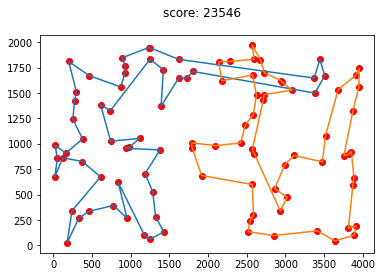

In [ ]:
draw_best(ver_data, lengths, greedyCycle, 'cycleB')

# LAB 2

## Tworzenie możliwych ruchów dla podanego wierzchołka

In [ ]:
def swap_vertex(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  copy = copy[copy.index(vertex)+1:]
  n = len(copy)
  return list(zip(["vertex"]*(n), copy, [vertex]*(n), [i]*(n)))

In [ ]:
def swap_vertex_cycle(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  n = len(copy)
  return list(zip(["cycle"]*n, copy, [vertex]*(n), [i]*(n)))

In [ ]:
def swap_edges(vertex, list_of_vertex, i):
  copy = list_of_vertex[:-1]
  copy = copy[copy.index(vertex)+1:]
  n = len(copy)
  return list(zip(["edges"]*(n), copy, [vertex]*(n),  [i]*(n)))

## Obliczanie delty funkcji celu

In [ ]:
def calculate_delta(typ, distance_matrix, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig1+2], list1[min1]]+ distance_matrix[
                                                          list1[neig2], list1[max1]] + distance_matrix[list1[neig2-2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig1+2], list1[max1]]+ distance_matrix[
                                                          list1[neig2], list1[min1]] + distance_matrix[list1[neig2-2], list1[min1]]
    if abs(ind1-ind2)==1 or neig2==min1:
      delta2+=2*distance_matrix[list1[ind1], list1[ind2]]


  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1,ind2)
    neig1 = min1-1
    neig2 = (max1+1)%len(list1)
    if neig2==0 and min1==0:
      return 0
    delta1 = distance_matrix[list1[neig1], list1[min1]] + distance_matrix[list1[neig2], list1[max1]]
    delta2 = distance_matrix[list1[neig1], list1[max1]] + distance_matrix[list1[neig2], list1[min1]]

  elif typ=="cycle":
    if list_of_vertex2:
      list2 = list_of_vertex2[:-1]
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    indout1 = (ind1+1)%len(list1)
    indout2 = (ind2+1)%len(list2)
    delta1 = distance_matrix[list1[ind1-1], list1[ind1]] + distance_matrix[list1[indout1], list1[ind1]]+ distance_matrix[
                                                          list2[ind2-1], list2[ind2]] + distance_matrix[list2[indout2], list2[ind2]]
    delta2 = distance_matrix[list1[ind1-1], list2[ind2]] + distance_matrix[list1[indout1], list2[ind2]]+ distance_matrix[
                                                          list2[ind2-1], list1[ind1]] + distance_matrix[list2[indout2], list1[ind1]]
  return delta2-delta1

## Wykonywanie ruchu

In [ ]:
def move(typ, vertex1, vertex2, list_of_vertex1, list_of_vertex2 = None):
  list1 = list_of_vertex1[:-1]
  list2 = list_of_vertex2[:-1]
  if typ=="vertex":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    list1[ind1], list1[ind2] = list1[ind2], list1[ind1] 

  elif typ=="edges":
    ind1 = list1.index(vertex1)
    ind2 = list1.index(vertex2)
    min1, max1 = min(ind1,ind2), max(ind1, ind2)
    list1[min1:max1+1] = reversed(list1[min1:max1+1])

  else:
    ind1 = list1.index(vertex1)
    ind2 = list2.index(vertex2)
    list1[ind1], list2[ind2] = list2[ind2], list1[ind1]
    

  list1.append(list1[0])
  list2.append(list2[0])
  return list1, list2


## Algorytmy wykorzystane do rozwiązania zadania

In [ ]:
def steepest(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      delta = 0
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)

      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < delta:
          best_move = m
          delta = new_delta

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), delta)
          print()
      else:
        break
      

  return start_solution


In [ ]:
def greedy(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  while True:
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      for m in moves:
        i = m[3]
        new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
        if new_delta < 0:
          best_move = m
          break

      if best_move:
        i = best_move[3]
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution), new_delta)
          print()
      else:
        break
      

  return start_solution

In [ ]:
def random_wandering(distance_matrix, type_of_neigbhour=swap_vertex, start_solution = None, verbose=False):
  j = 0
  while j<100:
      j+=1
      best_move = None
      moves = []
      for kk in np.concatenate(start_solution):
        if kk in start_solution[0]:
          i=0
        else:
          i=1
        moves+=type_of_neigbhour(kk, start_solution[i], i)
        moves+=swap_vertex_cycle(kk, start_solution[(i+1)%2], i)
      random.shuffle(moves)
      m = moves[random.randint(0, len(moves)-1)]
      i = m[3]
      new_delta = calculate_delta(m[0], distance_matrix, m[2], m[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])
      if new_delta < 0:
        best_move = m

      if best_move:
        start_solution = move(best_move[0], best_move[2], best_move[1], start_solution[i], list_of_vertex2 = start_solution[(i+1)%2])

        if verbose:
          print(calculateCycleLength(distance_matrix, start_solution))
          print()
      
      

  return start_solution

time: 27.8 ms (started: 2022-04-03 12:43:20 +00:00)


## Uruchamianie eksperymentów

In [ ]:
def test_lab2(n, heuris, ver_data, algor = steepest, swap = swap_vertex):
  distance_matrix = createDistanceMatrix(ver_data)
  lengths = []
  best_length = np.inf
  best = None
  for i in range(n):
    start_node = i
    vertexes = heuris(distance_matrix, start_node)
    vertexes = algor(distance_matrix, swap, start_solution = vertexes, verbose = False)
    length = calculateCycleLength(distance_matrix, vertexes)
    if length < best_length:
      best = vertexes
      best_length = length
    lengths.append(length)
  return lengths, best, best_length

In [ ]:
def draw_best2(ver_data, best, length, filename = "cos"):
  for graph in best:
    x = ver_data[graph, 0]
    y = ver_data[graph,1]
    plt.plot(x, y)
  plt.scatter(ver_data[:, 0], ver_data[:, 1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')

In [ ]:
#load time measurement
!pip install ipython-autotime
%load_ext autotime

In [ ]:
ver_data = np.array(pd.read_csv('kroA100.txt', sep=' ', header=None).iloc[:, 1:])

time: 6.98 ms (started: 2022-04-03 13:33:01 +00:00)


In [ ]:
# algor to choose: steepest, greedy or random_wandering, swap: swap_edges or swap_vertex
lengt, best, bl = test_lab2(100, two_regret, ver_data, algor = steepest, swap = swap_edges)

time: 3min 10s (started: 2022-04-03 13:33:03 +00:00)


In [ ]:
print(f'{round(sum(lengt)/len(lengt))} ({min(lengt)}-{max(lengt)})')

24179 (22534-27517)
time: 2.58 ms (started: 2022-04-03 13:49:30 +00:00)


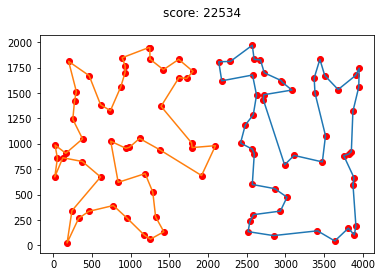

time: 703 ms (started: 2022-04-03 13:49:39 +00:00)


In [ ]:
draw_best2(ver_data, best, bl, filename="steepest")

# LAB 3

In [ ]:
!pip install tspy
!pip install TSPLib95

import tsplib95
import numpy as np
import matplotlib.pyplot as plt
from tspy import TSP
from random import randint
import time

In [ ]:
tsp = TSP()

kroAProblem = tsplib95.load('kroA200.tsp')
kroBProblem = tsplib95.load('kroB200.tsp')

kroAData = kroAProblem.as_name_dict()['node_coords']
kroBData = kroBProblem.as_name_dict()['node_coords']

verticesA = [kroAData[key] for key in kroAData]
verticesB = [kroBData[key] for key in kroBData]

time: 24.9 ms (started: 2022-05-09 00:09:59 +00:00)


In [ ]:
def distance_matrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [ ]:
def choose_nearest(matrix, invited_vertices, node):
  return np.argmin([matrix[node][i] if i not in invited_vertices and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculate_cycle_length(matrix, visited):
  sum = 0
  for graph in visited:
    sum += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])
  return sum

In [ ]:
def draw_plot(vertices, visited, length, filename = "x"):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  for i in vertices:
    plt.scatter(i[0], i[1], color='red')
  plt.suptitle(f'score: {int(length)}')
  plt.savefig(f'{filename}.jpg')
  plt.show()

time: 17.6 ms (started: 2022-05-09 00:22:54 +00:00)


In [ ]:
def greedy_nearest_neighbor(distance_matrix, start_node_1):

  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  visited_1 = [node_1]
  visited_2 = [node_2]

  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    if len(visited_1) <= len(visited_2):
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
      visited_1.append(vertex)
      node_1 = vertex
    else:
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
      visited_2.append(vertex)
      node_2 = vertex

  visited_1.append(visited_1[0])
  visited_2.append(visited_2[0])

  return visited_1, visited_2

In [ ]:
''' Struktura przechowywania danych
  {
    'wartość_ulepszenia': [
      [wierzchołek_1, wierzchołek_2],
      [wierzchołek_1, wierzchołek_2, wierzchołek_3, wierzchołek_4], # krawędziowe - pierwsza i druga, 1 z 4, 2 z 3
  ] '''

def sort_dict(mydict, rev = True):
  final = {}
  for key in sorted(mydict, reverse=rev):
    final[key] = mydict[key]
  return final

def check_for_change_vertices_in_one(matrix, visited):
  final_dictionary = { }
  
  for index, item in enumerate(visited[1:-1]):
    for next_index, next_item in enumerate(visited[index + 2:-1]):
      previous = matrix[item][visited[index + 1]] + matrix[next_item][visited[next_index + 1]] + \
        matrix[item][visited[index - 1]] + matrix[next_item][visited[next_index - 1]]

      next = matrix[item][visited[next_index + 1]] + matrix[next_item][visited[index + 1]] + \
        matrix[item][visited[next_index - 1]] + matrix[next_item][visited[index - 1]]

      delta = previous - next
      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([item, next_item])
        else:
          final_dictionary[delta] = [[item, next_item]]

  return sort_dict(final_dictionary)


def check_for_change_edges_in_one(matrix, visited):
  final_dictionary = { }
  
  for index, item in enumerate(visited[1:-1]):
    for next_index, next_item in enumerate(visited[index + 1:-1]):
      previous = matrix[item][visited[index + 1]] + matrix[next_item][visited[next_index + 1]]

      next = matrix[item][next_item] + matrix[visited[next_index + 1]][visited[index + 1]]

      delta = previous - next
      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([item, visited[index + 1], next_item, visited[next_index + 1]])
        else:
          final_dictionary[delta] = [[item, visited[index + 1], next_item, visited[next_index + 1]]]

  return sort_dict(final_dictionary)


def check_for_change_vertices(matrix, visited_1, visited_2):
  final_dictionary = { }
  
  for index, item in enumerate(visited_1[1:-1]):
    for next_index, next_item in enumerate(visited_2[1:-1]):
      previous = matrix[item][visited_1[index + 1]] + matrix[next_item][visited_2[next_index + 1]] + \
        matrix[item][visited_1[index - 1]] + matrix[next_item][visited_2[next_index - 1]]

      next = matrix[item][visited_2[next_index + 1]] + matrix[next_item][visited_1[index + 1]] + \
        matrix[item][visited_2[next_index - 1]] + matrix[next_item][visited_1[index - 1]]

      delta = previous - next

      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([item, next_item])
        else:
          final_dictionary[delta] = [[item, next_item]]

  return sort_dict(final_dictionary)


def check_for_vertice(matrix, vertex, visited_1, visited_2):
  final_dictionary = {}

  if vertex in visited_1:
    visited = visited_1
    visited_next = visited_2
  else:
    visited = visited_2
    visited_next = visited_1

  index = visited.index(vertex)
  prev_index = index - 1 if index > 0 else -2
  next_visited_index = index + 1 if index < len(visited) - 1 else 1
  
  for next_index, next_item in enumerate(visited_next[1:-1]):
    previous = matrix[vertex][visited[next_visited_index]] + matrix[next_item][visited_next[next_index + 1]] + \
        matrix[vertex][visited[prev_index]] + matrix[next_item][visited_next[next_index - 1]]

    next = matrix[vertex][visited_next[next_index + 1]] + matrix[next_item][visited[next_visited_index]] + \
        matrix[vertex][visited_next[next_index - 1]] + matrix[next_item][visited[prev_index]]

    delta = previous - next

    if delta > 0: 
      if delta in final_dictionary:
        final_dictionary[delta].append([vertex, next_item])
      else:
        final_dictionary[delta] = [[vertex, next_item]]

  for next_index, next_item in enumerate(visited[1:-1]):
    if next_item != vertex and visited[next_index + 1] != vertex:
      previous = matrix[vertex][visited[next_visited_index]] + matrix[next_item][visited[next_index + 1]]

      next = matrix[vertex][next_item] + matrix[visited[next_index + 1]][visited[next_visited_index]]

      delta = previous - next
      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([vertex, visited[next_visited_index], next_item, visited[next_index + 1]])
        else:
          final_dictionary[delta] = [[vertex, visited[next_visited_index], next_item, visited[next_index + 1]]]

  
  for next_index, next_item in enumerate(visited[:-1]):
     if next_item != vertex and visited[next_index + 1] != vertex and visited[next_index - 1] != vertex:

      previous = matrix[vertex][visited[next_visited_index]] + matrix[next_item][visited[next_index + 1]] + \
        matrix[vertex][visited[prev_index]] + matrix[next_item][visited[next_index - 1]]

      next = matrix[vertex][visited[next_index + 1]] + matrix[next_item][visited[next_visited_index]] + \
        matrix[vertex][visited[next_index - 1]] + matrix[next_item][visited[prev_index]]

      delta = previous - next

      if delta > 0: 
        if delta in final_dictionary:
          final_dictionary[delta].append([vertex, next_item])
        else:
          final_dictionary[delta] = [[vertex, next_item]]


  return sort_dict(final_dictionary)

In [ ]:
def look_for_better_moves(matrix, moves_list, last_move, visited_1, visited_2):
  if len(moves_list) > 0:
    for vertex in last_move:
      # print('func', moves_list)
      # TODO: czy powinniśmy robić update wartości ruchu? bo w teorii dopiero potem sprawdzamy, czy rzeczywiscie jest wart?
      moves_list = sort_dict({**moves_list, **(check_for_vertice(matrix, vertex, visited_1, visited_2))})
    
    return moves_list

  else:
    moves_list = check_for_change_edges_in_one(matrix, visited_1)
    moves_list = sort_dict({**moves_list, **(check_for_change_vertices_in_one(matrix, visited_1))})
    moves_list = sort_dict({**moves_list, **(check_for_change_edges_in_one(matrix, visited_2))})
    moves_list = sort_dict({**moves_list, **(check_for_change_vertices_in_one(matrix, visited_2))})
    moves_list = sort_dict({**moves_list, **(check_for_change_vertices(matrix, visited_1, visited_2))})

  return moves_list

In [ ]:
def steepest_list_better_moves(matrix, visited_1, visited_2):
  # od najlepszego do najgorszego
  moves_list = {}
  # index ruchu do wykonania
  next_move = -2

  i = 0
  while next_move is not None and i <2000:
    i += 1
    moves_list = look_for_better_moves(matrix, moves_list, next_move, visited_1, visited_2)
    
    next_move = None
    
    for key, value in list(moves_list.items()):
      # print(key, value)
      if value:
        for move in value:
          if next_move is not None:
          # TODO: przejrzeć cały słownik do końca i usunąć ruchy związane z tymi wierzchołkami
            for elem in move:
              if elem in next_move:
                if key in moves_list and value.remove(move) is None:
                  moves_list.pop(key)
                else:
                  moves_list[key] = value
                break
          # break


          # print(move, value, moves_list[key])
          if len(move) == 4:

            # krawędzie, które można zastosować teraz
            if set(move).issubset(visited_1):
              visited = visited_1
            elif set(move).issubset(visited_1):
              visited = visited_2
            else:
              visited = None
            
            if visited is not None:
              if ((visited.index(move[0]) < visited.index(move[1]) and visited.index(move[2]) < visited.index(move[3])) \
                or (visited.index(move[0]) > visited.index(move[1]) and visited.index(move[2]) > visited.index(move[3]))) \
                and visited.index(move[1]) != 0 and visited.index(move[2]) != 0 and visited.index(move[1]) != -1 and visited.index(move[2]) != -1:

                # odwrócić listę pomiędzy indeksami 1 i 2
                if visited == visited_1:
                  if visited.index(move[0]) < visited.index(move[1]):
                    index_prev = visited_1.index(move[1])
                    index_next = visited_1.index(move[3])
                  else:
                    index_prev = visited_1.index(move[0])
                    index_next = visited_1.index(move[2])

                  visited_1[index_prev:index_next] = visited_1[index_prev:index_next:-1]

                  visited_1[-1] = visited_1[0]

                else:
                  if visited.index(move[0]) < visited.index(move[1]):
                    index_prev = visited_1.index(move[1])
                    index_next = visited_1.index(move[3])
                  else:
                    index_prev = visited_1.index(move[0])
                    index_next = visited_1.index(move[2])

                  visited_2[index_prev:index_next] = visited_2[index_prev:index_next:-1]

                  visited_2[-1] = visited_2[0]

                next_move = move
                if key in moves_list and value.remove(move) is None:
                  moves_list.pop(key)
                else:
                  moves_list[key] = value
                break

            # krawędzie, które nie znajdują się w tych samych pętlach lub nie następują po sobie
            else:
              if key in moves_list and value.remove(move) is None:
                moves_list.pop(key)
              else:
                moves_list[key] = value

          else:
            if move[0] in visited_1:
              visited = visited_1
            elif move[0] in visited_2:
              visited = visited_2
            
            index = visited.index(move[0])
            next_item = visited[index + 1]
            prev_item = visited[index - 1]

            if move[1] in visited_1:
              visited = visited_1
            elif move[1] in visited_2:
              visited = visited_2
            
            index_2 = visited.index(move[1])
            next_item_2 = visited[index_2 + 1]
            prev_item_2 = visited[index_2 - 1]

            if next_item != move[1] and prev_item != move[1] and next_item_2 != move[0] and prev_item_2 != move[0]:

              if move[1] in visited_1:

                if move[0] in visited_1:
                  if visited_1.index(move[0]) == 0:
                    visited_1[-1] = move[1]

                  elif visited_1.index(move[1]) == 0:
                    visited_1[-1] = move[0]

                  visited_1[visited_1.index(move[0])] = move[1]
                  visited_1[visited_1.index(move[1])] = move[0]

                else:
                  if visited_2[0] == move[0]:
                    visited_2[-1] = move[1]
                    visited_2[0] = move[1]
                  else:
                    visited_2[visited_2.index(move[0])] = move[1]

                  if visited_1[0] == move[1]:
                    visited_1[-1] = move[0]
                    visited_1[0] = move[0]
                  else:
                    visited_1[visited_1.index(move[1])] = move[0]

              else:
                if move[0] in visited_1:
                  if visited_1[0] == move[0]:
                    visited_1[-1] = move[1]
                    visited_1[0] = move[1]
                  else:
                    visited_1[visited_1.index(move[0])] = move[1]

                  if visited_2[0] == move[1]:
                    visited_2[-1] = move[0]
                    visited_2[0] = move[0]
                  else:
                    visited_2[visited_2.index(move[1])] = move[0]

                else:
                  if visited_2.index(move[0]) == 0:
                    visited_2[-1] = move[1]
                  elif visited_2.index(move[1]) == 0:
                    visited_2[-1] = move[0]

                  visited_2[visited_2.index(move[0])] = move[1]
                  visited_2[visited_2.index(move[1])] = move[0]

              next_move = move
              if key in moves_list and value.remove(move) is None:
                moves_list.pop(key)
              else:
                moves_list[key] = value
              break
              
        if len(set(visited_1)) != 100 or  len(set(visited_2)) != 100:
          visited_1[-1] = visited_1[0]
          visited_2[-1] = visited_2[0]

  # print(i)
  return visited_1, visited_2

time: 264 ms (started: 2022-05-08 23:55:54 +00:00)


In [ ]:
# zamiana wierzhołków MIĘDZY grafami
def steepest_change_vertices_outer_nearest(matrix, visited_1, visited_2, nearest):
  best = -np.inf
  vertex_to_change = []

  for first in range(len(visited_1) - 1):
    temp = [value for value in nearest[first] if value in visited_2[:-1]]
    for value in temp: 
      second = np.where(visited_2 == value)[0][0]
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (second == 0):
        second_pre = second-2
      previous = matrix[visited_1[first], visited_1[first_pre]] +\
                 matrix[visited_1[first], visited_1[first_next]] +\
                 matrix[visited_2[second], visited_2[second_pre]] +\
                 matrix[visited_2[second], visited_2[second_next]]
                 
      next = matrix[visited_2[second], visited_1[first_pre]] +\
             matrix[visited_2[second], visited_1[first_next]] +\
             matrix[visited_1[first], visited_2[second_pre]] +\
             matrix[visited_1[first], visited_2[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited_1[first], visited_2[second]]
  
  if (best <= 0):
    return

  visited_1[np.where(visited_1 == vertex_to_change[0])[0][0]] = vertex_to_change[1]
  visited_2[np.where(visited_2 == vertex_to_change[1])[0][0]] = vertex_to_change[0]

time: 26.2 ms (started: 2022-05-08 23:47:30 +00:00)


In [ ]:
# zamiana wierzhołków WEWNĄTRZ grafu
def steepest_change_vertices_inner_nearest(matrix, visited, nearest):
  best = -np.inf
  vertex_to_change = []
  for first in range(len(visited) - 2): 
    temp = [value for value in nearest[first] if value in visited[first + 1:len(visited) - 1]]
    for value in temp: 
      second = np.where(visited == value)[0][0]
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (first_next == second): # warunek sąsiedztwa
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[second]] +\
                  matrix[visited[second], visited[first]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first]] +\
              matrix[visited[first], visited[second]] +\
              matrix[visited[first], visited[second_next]]
      else:
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[first_next]] +\
                  matrix[visited[second], visited[second_pre]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first_next]] +\
              matrix[visited[first], visited[second_pre]] +\
              matrix[visited[first], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited[first], visited[second]]
  if (best <= 0):
    return

  visited[np.where(visited == vertex_to_change[0])[0][0]] = vertex_to_change[1] 
  visited[np.where(visited == vertex_to_change[1])[0][0]] = vertex_to_change[0]

time: 28.7 ms (started: 2022-05-08 23:47:31 +00:00)


In [ ]:
# zamiana krawędzi WEWNĄTRZ grafu
def steepest_change_edges_inner_nearest(matrix, visited, nearest):
  best = -np.inf
  index_to_change = []
  for first in range(len(visited) - 2):
    temp = [value for value in nearest[first] if value in visited[first + 2: len(visited) - 1]]
    for value in temp: 
      second = np.where(visited == value)[0][0]
      first_next = first+1
      second_next = second+1
      if (visited[first] == visited[second_next]):
        continue

      previous = matrix[visited[first], visited[first_next]] +\
                matrix[visited[second], visited[second_next]]
      next = matrix[visited[first], visited[second]] +\
            matrix[visited[first_next], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        index_to_change = [first_next, second_next]
        
  if (best <= 0):
    return
  
  visited[index_to_change[0]:index_to_change[1]] = visited[index_to_change[0]:index_to_change[1]][::-1]

time: 20.3 ms (started: 2022-05-08 23:47:34 +00:00)


In [ ]:
def steepest_candidate_movements(matrix, visited_1, visited_2, k = 10):

  nearest_matrix = np.zeros((len(matrix), k))

  for vertex in range(len(matrix)):
    temp = sorted(matrix[vertex])[1:k+1]
    
    i = 0
    for index, value in enumerate(temp):
      if i > len(np.where(matrix[vertex] == value)[0]):
        i = 0
      if len(np.where(matrix[vertex] == value)[0]) == 1:
        nearest_matrix[vertex][index] = np.where(matrix[vertex] == value)[0]
      else:
        nearest_matrix[vertex][index] = np.where(matrix[vertex] == value)[0][i]
        
  # inner graph 1
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_edges_inner_nearest(matrix, visited_1, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_1])
    if (next >= previous):
      break

  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_edges_inner_nearest(matrix, visited_2, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_2])
    if (next >= previous):
      break

  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer_nearest(matrix, visited_1, visited_2, nearest_matrix)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    if (next >= previous):
      break

  return visited_1, visited_2

time: 30 ms (started: 2022-05-08 23:47:36 +00:00)


In [ ]:
#load time measurement
# !pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1.82 ms (started: 2022-05-08 23:46:52 +00:00)


46261
37583
41258.397959183676


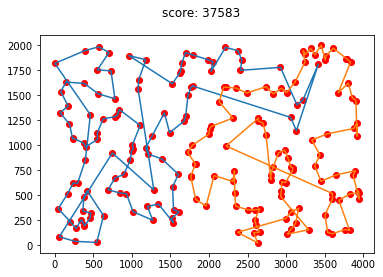

time: 28.3 s (started: 2022-05-09 02:52:13 +00:00)


In [ ]:
version = verticesB
matrix = distance_matrix(version)
best_sum = np.inf
best = None
sums = []
for i in range(100):
  # print(i)
  start_node_1 = randint(0, len(matrix)-1)
  if version == verticesB and start_node_1 in [106,45,8]:
    continue
  # print(start_node_1)
  visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
  final_visited_1, final_visited_2 = steepest_candidate_movements(matrix, visited_1, visited_2)
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  sums.append(sum)
  if sum<best_sum:
    best = [final_visited_1, final_visited_2]
    best_sum = sum
    


print(max(sums))
print(min(sums))
print(np.mean(sums))
draw_plot(verticesB, best, min(sums), "kandydacki")




298672
38070
49903.47


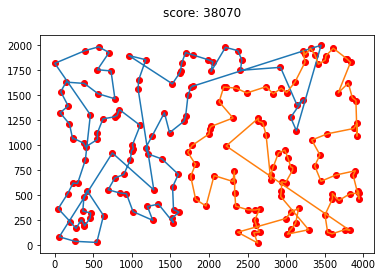

time: 1min 21s (started: 2022-05-09 00:51:09 +00:00)


In [ ]:
matrix = distance_matrix(verticesB)
best_sum = np.inf
best = None
sums = []

for i in range(100):
  start_node_1 = randint(0, len(matrix)-1)
  visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
  final_visited_1, final_visited_2 = steepest_list_better_moves(matrix, list(visited_1), list(visited_2))
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  sums.append(sum)
  if sum<best_sum:
    best = [final_visited_1, final_visited_2]
    best_sum = sum

print(max(sums))
print(min(sums))
print(np.mean(sums))
draw_plot(verticesB, best, min(sums), "lepszeRuchy")

